In [1]:
from google.colab import files
uploaded = files.upload()

Saving anime.csv to anime.csv


In [4]:
# Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("anime.csv")

# Tampilkan informasi dasar
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Advent

In [5]:
# Salin dataframe agar aman
data = df.copy()

# Ubah 'episodes' ke numerik (ganti non-numeric dengan NaN lalu isi median)
data['episodes'] = pd.to_numeric(data['episodes'], errors='coerce')
data['episodes'].fillna(data['episodes'].median(), inplace=True)

# Buat fitur jumlah genre
data['num_genres'] = data['genre'].apply(lambda x: len(str(x).split(',')))

# Ambil 10 genre paling sering muncul
from collections import Counter
top_genres = [g for g, _ in Counter(
    [i.strip() for sub in data['genre'].dropna().str.split(',') for i in sub]
).most_common(10)]

# One-hot encoding untuk top 10 genre
for g in top_genres:
    data[g] = data['genre'].apply(lambda x: 1 if g in str(x) else 0)

# Label encode kolom 'type' (target klasifikasi)
le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

# Pilih fitur numerik untuk model
features = ['episodes', 'members', 'num_genres'] + top_genres


/tmp/ipython-input-1060257153.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['episodes'].fillna(data['episodes'].median(), inplace=True)


Distribusi label:
 type_encoded
5    3787
3    3311
0    2348
4    1676
2     659
1     488
Name: count, dtype: int64

=== Support Vector Classifier ===
              precision    recall  f1-score   support

       Movie       0.46      0.46      0.46       470
       Music       0.16      0.83      0.27        98
         ONA       0.14      0.39      0.20       132
         OVA       0.53      0.21      0.30       662
     Special       0.30      0.24      0.27       335
          TV       0.94      0.72      0.81       757

    accuracy                           0.45      2454
   macro avg       0.42      0.47      0.39      2454
weighted avg       0.58      0.45      0.48      2454


=== Random Forest Classifier ===
              precision    recall  f1-score   support

       Movie       0.57      0.58      0.58       470
       Music       0.29      0.34      0.31        98
         ONA       0.23      0.19      0.21       132
         OVA       0.62      0.68      0.65       662

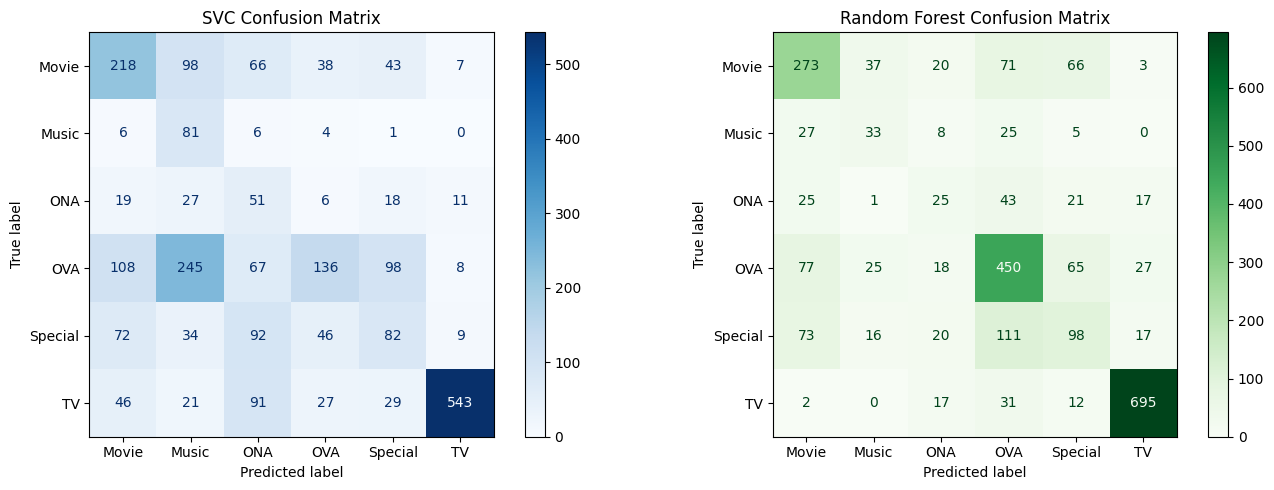

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Pastikan tidak ada NaN pada kolom type ---
data = data.dropna(subset=['type']).reset_index(drop=True)

# --- Split Data ---
X_class = data[features]
y_class = data['type_encoded']

# Cek distribusi label dulu (penting untuk stratify)
print("Distribusi label:\n", pd.Series(y_class).value_counts())

# Stratified split agar proporsi label seimbang di train/test
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# --- Standarisasi untuk SVM ---
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

# --- Model 1: Support Vector Classifier ---
svc = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svc.fit(X_train_c_scaled, y_train_c)
y_pred_svc = svc.predict(X_test_c_scaled)

# --- Model 2: Random Forest Classifier ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_c, y_train_c)
y_pred_rf = rf.predict(X_test_c)

# --- Evaluasi Aman ---
print("\n=== Support Vector Classifier ===")
labels_svc = np.unique(np.concatenate([y_test_c, y_pred_svc]))
print(classification_report(
    y_test_c, y_pred_svc,
    labels=labels_svc,
    target_names=[str(le.inverse_transform([i])[0]) for i in labels_svc]
))

print("\n=== Random Forest Classifier ===")
labels_rf = np.unique(np.concatenate([y_test_c, y_pred_rf]))
print(classification_report(
    y_test_c, y_pred_rf,
    labels=labels_rf,
    target_names=[str(le.inverse_transform([i])[0]) for i in labels_rf]
))

# --- Plot Confusion Matrix ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test_c, y_pred_svc,
    display_labels=[str(le.inverse_transform([i])[0]) for i in labels_svc],
    cmap='Blues', ax=axes[0]
)
axes[0].set_title("SVC Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(
    y_test_c, y_pred_rf,
    display_labels=[str(le.inverse_transform([i])[0]) for i in labels_rf],
    cmap='Greens', ax=axes[1]
)
axes[1].set_title("Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()



=== Linear Regression ===
MAE  : 0.6531
MSE  : 0.7132
RMSE : 0.8445
R²   : 0.2964

=== Support Vector Regressor ===
MAE  : 0.5730
MSE  : 0.5898
RMSE : 0.7680
R²   : 0.4181


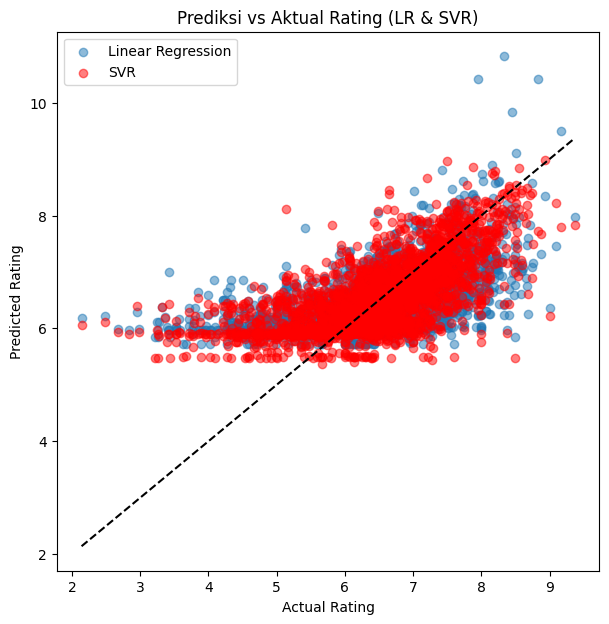

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Split data untuk regresi
X_reg = data[features]
y_reg = data['rating'].fillna(data['rating'].mean())

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Scaling
scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

# --- Model 1: Linear Regression ---
lr = LinearRegression()
lr.fit(X_train_r_scaled, y_train_r)
y_pred_lr = lr.predict(X_test_r_scaled)

# --- Model 2: Support Vector Regressor ---
svr = SVR(kernel='rbf')
svr.fit(X_train_r_scaled, y_train_r)
y_pred_svr = svr.predict(X_test_r_scaled)

# --- Evaluasi Fungsi ---
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

evaluate_model(y_test_r, y_pred_lr, "Linear Regression")
evaluate_model(y_test_r, y_pred_svr, "Support Vector Regressor")

# --- Visualisasi ---
plt.figure(figsize=(7, 7))
plt.scatter(y_test_r, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.scatter(y_test_r, y_pred_svr, alpha=0.5, label='SVR', color='red')
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'k--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Prediksi vs Aktual Rating (LR & SVR)")
plt.legend()
plt.show()
